In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
# Core packages
import pygmo as pg
import numpy as np
from math import pi
from dotmap import DotMap

# For creating mesh
import mesh_utility

# For computing the next state
import equations_of_motion

# For optimization using pygmo
from udp_initial_condition import udp_initial_condition

# For computing trajectory
import trajectory_tools
import pykep as pk

# For Plotting
import matplotlib.pyplot as plt

# For cProfile evaluation
import cProfile
import pstats

In [48]:
def setup_parameters():
    """Set up of required hyperparameters for the optimization scheme. 

    Returns:

        body_args (dotmap.DotMap): Parameters related to the celestial body:
            density (float): Body density of celestial body.
            mu (float): Gravitational parameter for celestial body.
            declination (float): Declination angle of spin axis.
            right_ascension (float): Right ascension angle of spin axis.
            spin_period (float): Rotational period around spin axis of the body.

        integrator_args (dotmap.DotMap): Specific parameters related to the integrator:
            algorithm (int): Integer representing specific integrator algorithm.
            dense_output (bool): Dense output status of integrator.
            rtol (float): Relative error tolerance for integration.
            atol (float): Absolute error tolerance for integration.

        problem_args (dotmap.DotMap): Parameters related to the problem:
            start_time (float): Start time (in seconds) for the integration of trajectory.
            final_time (float): Final time (in seconds) for the integration of trajectory.
            initial_time_step (float): Size of initial time step (in seconds) for integration of trajectory.
            target_squared_altitude (float): Squared value of the satellite's orbital target altitude.
            radius_bounding_sphere (float): Radius of the bounding sphere representing risk zone for collisions with celestial body.
            event (int): Event configuration (0 = no event, 1 = collision with body detection)
        
        lower_bounds (np.ndarray): Lower boundary values for the initial state vector.
        upper_bounds (np.ndarray): Lower boundary values for the initial state vector.
                
        population_size (int): Number of chromosomes to compare at each generation.
        number_of_generations (int): Number of generations for the genetic opimization.
    """
    args = DotMap()

    # Setup body parameters
    args.body.density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.mu = 665.666                   # Gravitational parameter for 67P/C-G
    args.body.declination = 64               # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.right_ascension = 69           # [degrees] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.spin_period = 12.06*3600       # [seconds] https://sci.esa.int/web/rosetta/-/14615-comet-67p
    args.body.spin_velocity = (2*pi)/args.body.spin_period
    args.body.spin_axis = equations_of_motion.setup_spin_axis(args)

    # Setup specific integrator parameters:
    args.integrator.algorithm = 3
    args.integrator.dense_output = True
    args.integrator.rtol = 1e-12
    args.integrator.atol = 1e-12

    # Setup problem parameters
    args.problem.start_time = 0                     # Starting time [s]
    args.problem.final_time = 20*3600.0             # Final time [s]
    args.problem.initial_time_step = 600            # Initial time step size for integration [s]
    args.problem.radius_bounding_sphere = 4000      # Radius of spherical risk-zone for collision with celestial body [m]
    args.problem.target_squared_altitude = 8000**2  # Target altitude squared [m]
    args.problem.event = 1                          # Event configuration (0 = no event, 1 = collision with body detection)
    

    # Defining the parameter space for the optimization
    #   (Parameters are defined in osculating orbital elements)
    a = [5000, 15000] # Semi-major axis
    e = [0, 1]        # Eccentricity [0, 1]
    o = [0, 2*pi]     # Right ascension of ascending node [0,2*pi]
    w = [0, 2*pi]     # Argument of periapsis [0, 2*pi]
    i = [0, pi]       # Inclination [0, pi] 
    ea = [0, 2*pi]    # Eccentric anomaly [0, 2*pi]

    lower_bounds = np.array([a[0], e[0], i[0], o[0], w[0], ea[0]])
    upper_bounds = np.array([a[1], e[1], i[1], o[1], w[1], ea[1]])


    # Optimization parameters
    population_size = 10 
    number_of_generations = 32 

    return args, lower_bounds, upper_bounds, population_size, number_of_generations

In [49]:
# Main script:

def run():
    """
    Main function for optimizing the initial state for deterministic trajectories around a 
    small celestial body using a mesh.
    """
    
    print("Retrieving user defined parameters...")
    args, lower_bounds, upper_bounds, population_size, number_of_generations = setup_parameters()

    # Creating the mesh (TetGen)
    print("Creating the mesh...")
    args.mesh.body, args.mesh.vertices, args.mesh.faces, args.mesh.largest_body_protuberant = mesh_utility.create_mesh()
    
    # Setup User-Defined Problem (UDP)
    print("Setting up the UDP...")
    udp = udp_initial_condition(args, lower_bounds, upper_bounds)
    prob = pg.problem(udp)

    # Setup optimization algorithm
    print("Setting up the optimization algorithm...")
    assert population_size >= 7
    algo = pg.algorithm(pg.sade(gen = number_of_generations))
    pop = pg.population(prob = prob, size = population_size)
    
    # Run optimization
    print("Initializing the optimization:")
    algo.set_verbosity(1)
    pop = algo.evolve(pop)

    # Logs for output
    print("Champion fitness value: ", pop.champion_f) 
    print("Champion chromosome: ", pop.champion_x) 

    # Retrieving champion chromosome
    x = pop.champion_x

    # Convert osculating orbital elements to cartesian for integration
    r, v = pk.par2ic(E=x, mu=args.body.mu)
    x_cartesian = np.array(r+v)

    # Setup Equations of motion
    #eq_of_motion = EquationsOfMotion(args)

    # Re-compute optimized trajectory
    trajectory_info, _, _  = trajectory_tools.compute_trajectory(x_cartesian, args, equations_of_motion.compute_motion)

    # Plot optimized trajectory
    trajectory_tools.plot_trajectory(trajectory_info[0:3,:], args.mesh.body)

    plt.plot(trajectory_info[0,:],trajectory_info[1,:])

def main():
    run()

if __name__ == "__main__":
    cProfile.run("main()", "output.dat")

    with open("output_time.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("time").print_stats()
    
    with open("output_calls.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("calls").print_stats()


Retrieving user defined parameters...
Creating the mesh...
Setting up the UDP...
Setting up the optimization algorithm...
Initializing the optimization:

   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10    6.25124e+07       0.376501        0.59087        243.303          1e+30
      2             20    5.55865e+07       0.800509        0.59087        1966.26          1e+30
      3             30    5.55865e+07       0.800509        0.59087        1967.75          1e+30
      4             40    5.55865e+07       0.800509        0.59087        1966.74          1e+30
      5             50    1.51497e+07       0.246927       0.772639        3228.08    2.72404e+08
      6             60    1.51497e+07       0.246927       0.772639        2463.29    2.39066e+08
      7             70    1.51497e+07       0.246927       0.772639        5595.79    2.11077e+08
      8             80    1.51497e+07       0.246927       0.7

KeyboardInterrupt: 

In [16]:
x = [8.81396249e+03, 2.05980394e-01, 3.01574106e+00, 5.48612161e+00, 4.22967630e+00, 1.38804306e+00]

In [17]:
print("Retrieving user defined parameters...")
args, lower_bounds, upper_bounds, population_size, number_of_generations = setup_parameters()

# Creating the mesh (TetGen)
print("Creating the mesh...")
args.mesh.body, args.mesh.vertices, args.mesh.faces, args.mesh.largest_body_protuberant = mesh_utility.create_mesh()

# Convert osculating orbital elements to cartesian for integration
r, v = pk.par2ic(E=x, mu=args.body.mu)
x_cartesian = np.array(r+v)


# Compute optimized trajectory
trajectory = Trajectory_class(args)

Retrieving user defined parameters...
Creating the mesh...


In [18]:

trajectory_info, _, _  = trajectory.compute_trajectory(x_cartesian)

2023-03-07 12:12:11.042 (8909.819s) [           19CA4]       vtkAxesActor.cxx:424   WARN| One or more normalized shaft lengths       are < 0 or > 1 and may produce unexpected results.


BokehModel(combine_events=True, render_bundle={'docs_json': {'1c8d8f76-192e-46d2-b67e-9ac57fe68b99': {'defs': …

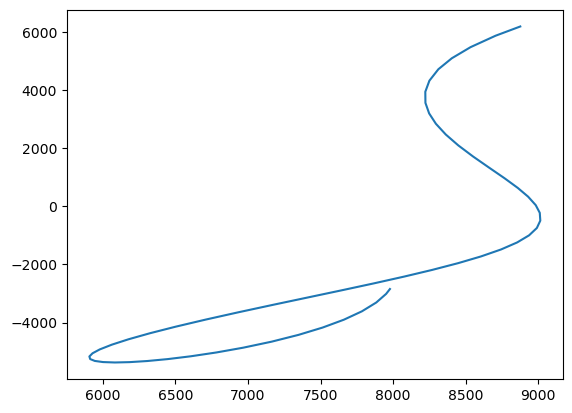

In [19]:

# Plot optimized trajectory
Trajectory.plot_trajectory(trajectory_info[0:3,:], args.mesh.body)

plt.plot(trajectory_info[0,:],trajectory_info[1,:])